# (7.5.2) Introdução da referência

Até agora vimos como resolver o problema da regulação de estados apenas para zerar o estado final. No entanto, o objetivo do controle é fazer a saída rastrear a referência $r$.

Uma forma simples de fazer isso é usando o sinal de controle:
$$
\begin{align*}
u &= -\mathbf{Kx}+(N_u+\mathbf{K}\mathbf{N_x})r
\end{align*}
$$
onde $\mathbf{K}$ é o vetor de ganhos conforme já definimos e $N_u$ e $\mathbf{N_x}$ são as soluções do sistema
$$
\begin{align*}
\left[\begin{array}{cc}\mathbf{F} & \mathbf{G}\\ \mathbf{H} & J \end{array}\right]
\left[\begin{array}{cc}\mathbf{N_x}\\ N_u\end{array}\right] = 
\left[\begin{array}{cc}\mathbf{0}\\ 1\end{array}\right]
\end{align*}
$$

Se tiver interesse, a dedução para o método é simples e pode ser encontrada na seção 7.5.2 do livro texto.

É interessante visualizar como essa estratégia funciona do ponto de vista da rota de sinal. Estude a figura 7.15 a seguir:
<p align="center">
<img src="Fig7.15.svg" width="80%">
</p>

Repare que a parte (b) da figura é apenas uma simplificação, mostrando que o controle funciona como uma realimentação negativa normal do sistema, mas a referência entra na malha multiplicada por uma constante.

<p align="center">
<img src="Ex.7.18.svg" width="80%">
</p>

Esse é o sistema do pêndulo novamente. As matrizes $\mathbf{F}$ e $\mathbf{G}$ já são conhecidas. Também usaremos:
$$
\begin{align*}
\mathbf{H} &=\left[\begin{array}{cc}1 & 0\end{array}\right]\\
J &=0
\end{align*}
$$


Para resolver o problema vamos montar o sistema de equações da seguinte maneira
$$
\begin{align*}
\left[\begin{array}{cc}\mathbf{F} & \mathbf{G}\end{array}\right] &= \mathbf{M_1}\\
\left[\begin{array}{cc}\mathbf{H} & J\end{array}\right] &= \mathbf{M_2}\\
\left[\begin{array}{cc}\mathbf{M_1} \\ \mathbf{M_2}\end{array}\right] &= \mathbf{M}
\end{align*}
$$
e o sistema vai ser resolvido como $\mathbf{M}^{-1}\mathbf{v}$, onde 
$$
\begin{align*}
    \mathbf{v} &=\left[\begin{array}{ccc}0 & 0 & 1\end{array}\right]^T 
\end{align*}
$$


In [2]:
import numpy as np

# Define as matrizes do sistema
w0 = 1
F = np.matrix([[0,1],[-w0**2,0]])
G = np.matrix([[0],[1]])
H = np.matrix([1,0])
J = np.matrix([0])

# Concatena primeiro as matrizes horizontalmente
M1 = np.hstack((F,G))
M2 = np.hstack((H,J))
# Agora concatena as duas anteriores, mas verticalmente
M = np.vstack((M1,M2))
print(M)
# Agora define o vetor do lado direito da equação
v = np.matrix([0,0,1]).T

# Calcula inversa e já multiplica por v para achar o resultado final
NN = np.matmul( np.linalg.inv(M), v)

# Precisamos agora separar em partes. Um pedaço do vetor vai multiplicar K e o outro vai se somar ao resultado

# Pega apenas os elementos 0 e 1
Nx = NN[0:2]
# Pega apenas o elemento 2
Nu = NN[2]

# Vamos recuperar o vetor de realimentação de estados
K = np.matrix([3*w0**2,4*w0])

# Podemos calcular o "ganho" da referência agora
N = Nu+np.matmul(K,Nx)
N

[[ 0  1  0]
 [-1  0  1]
 [ 1  0  0]]


matrix([[4.]])

In [3]:
M = np.array([[0,1,0],[-1,0,1],[1,0,0]])
np.linalg.inv(M) @ np.array([[0],[0],[1]])

array([[1.],
       [0.],
       [1.]])

É interessante testar o projeto agora usando uma resposta ao degrau. Porém, note que para isso, precisamos definir o sistema em malha fechada.

Em malha fechada as matrizes não serão as mesmas. A matriz $\mathbf{F}$ muda pois o sistema teve os estados realimentados. Além disso, a referência passa a ser a nossa entrada, já que o sinal $u$ foi substituido por $u=-\mathbf{Kx}+Nr$. A saída permanence a mesma $y=x_1$. 

Observe no código abaixo como o sistema é definido antes de calcular a resposta ao degrau.

<LinearIOSystem>: sys[2]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
States (2): ['x[0]', 'x[1]']

A = [[ 0.  1.]
     [-4. -4.]]

B = [[0.]
     [4.]]

C = [[1. 0.]]

D = [[0.]]



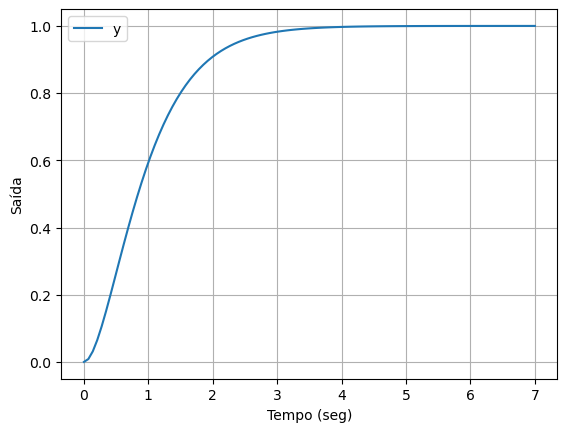

In [4]:
# Calcula as matrizes de malha fechada
F_malha_fechada = F - np.matmul(G,K)
G_malha_fechada = np.matmul(G,N)

# Define o sistema e calcula resposta ao degrau unitário
import control as ct
sys = ct.ss(F_malha_fechada,G_malha_fechada,H,0)
print(sys)
t,y = ct.step_response(sys,7)

# Plota os resultados, com algumas legendas
import matplotlib.pyplot as plt
plt.plot(t,y)
plt.grid()
plt.xlabel('Tempo (seg)')
plt.ylabel('Saída')
plt.legend('y')

Observação: se quisermos obter os outros sinais do sistema, tais como o sinal de controle usado e os estados, basta definir uma matriz $\mathbf{H}$. Isso é apenas para forçar o programa de simulação a devolver esses resultados para nós e não realmente definir uma saída nova para o sistema, com significado físico novo.

# (7.6) Escolha dos pólos

Deve estar claro até aqui que o sucesso do controle depende da escolha adequada do polinômio de malha fechada desejado. Esse polinômio deve ser construído tendo em mente todos os pólos de malha fechada desejados, não apenas os dominantes. 

Isso é importante quando temos um sistema de ordem maior que 2: os pólos que não serão dominantes devem ser escolhidos suficientemente distantes dos candidatos a dominantes.

Uma regra prática é, após escolher os dominantes, escolher os demais como reais, com a parte real de 3 a 5 vezes maior que a parte real dos dominantes. 

Lembre-se, porém, que se o deslocamento desses novos polos for muito grande em relação a posição inicial de malha aberta, os ganhos vão aumentar e consequentemente o sinal de controle vai "puxar" mais energia.

Outra coisa a se ter em mente na hora de escolher pólos de malha fechada são os zeros do sistema. **A realimentação de estados não altera a posição dos zeros**, isto é, se você não cancelar os zeros de malha aberta, eles permanecerão na mesma posição em malha fechada. 

Se os zeros (em malha aberta ou fechada, tanto faz) estiverem próximos dos pólos dominantes em malha fechada, a dinâmica que você projetou não irá funcionar (normalmente o overshoot será mais alto do que o projetado).

Uma forma de lidar com isso é posicionar um pólo extra sobre o zero que está atrapalhando seu projeto, mas **apenas se o zero for estável!**. O cancelamento vai criar um pequeno problema de controlabilidade, mas desde que tudo seja estável, não haverá problema. 

Note que devido às incertezas e os arredondamentos de projeto, podemos ter que fazer novas escolhas de polos até achar uma combinação que se ajuste ao que precisamos.

<p align="center">
<img src="Ex7.20.svg" width="80%">
</p>

Resolvemos no código abaixo

In [7]:
import control as ct
# Define as matrizes do sistema
F = np.array([  [0, 2, 0, 0, 0],
                [-.1, -.35, .1, .1, .75], 
                [0, 0, 0, 2, 0],
                [.4, .4, -.4, -1.4, 0],
                [0, -.03, 0, 0, -1]     ],dtype=float)
G = np.array([[0],[0],[0],[0],[1]])
H = np.array([1,0,0,0,0])
J = np.array([0])

In [4]:

# O livro sugere usar valores de xi e wn bem definidos
xi = 0.707
wn = 1/1.15
p = -xi*wn+1j*wn*np.sqrt(1-xi**2)
p

(-0.6147826086956522+0.6149683010872635j)

In [5]:

# Define os polos de malha fechada desejados. 
# Nessa matriz ficam os conjugados
polos_dom = np.array([p, np.conjugate(p)])
# Nessa ficam os extras, conforme a regra de 4x adotada. Note o recurso usado para definir 3 polos iguais
polos_extras = np.array([np.real(p)*4]*3)
# Agora juntamos as duas matrizes de polos numa só
polos_mf = np.concatenate((polos_dom,polos_extras))
print(polos_mf)



[-0.61478261+0.6149683j -0.61478261-0.6149683j -2.45913043+0.j
 -2.45913043+0.j        -2.45913043+0.j       ]


In [8]:

# Faz a alocação de polos agora
K = ct.acker(F,G,polos_mf)
print(K)

[[ 8.10043493 19.32922798  1.270173   -0.21391342  5.85695652]]


**Os valores são um pouco diferentes do livro. Tente descobrir a razão**

A seguir vamos calcular o ganho da referência e depois definir o sistema em malha fechada para estudar a resposta da saída e do sinal de controle

In [10]:
# Cálculo do ganho de referência. Mesmo do anterior, mas readequado para as dimensões do problema
M1 = np.hstack((F,G))
M2 = np.hstack((H,J))
M = np.vstack((M1,M2))
v = np.concatenate( ( np.zeros((5,1)), np.ones((1,1)) ) )

NN = np.matmul( np.linalg.inv(M), v)

Nx = NN[0:5]
Nu = NN[5]
N = Nu+np.matmul(K,Nx)
N

array([[9.37060794]])

In [11]:
# Sistema em malha fechada
Fm = F - np.matmul(G,K)
Gm = np.matmul(G,N)
H = np.array([[1,0,0,0,0],-K[0]])
J = np.array([[0],[N]],dtype=float)

sys = ct.ss(Fm,Gm,H,J)
t,y = ct.step_response(sys)

print(sys)

C:\Users\Rafael\AppData\Local\Temp\ipykernel_8488\2408602379.py:5: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  J = np.array([[0],[N]],dtype=float)


<LinearIOSystem>: sys[2]
Inputs (1): ['u[0]']
Outputs (2): ['y[0]', 'y[1]']
States (5): ['x[0]', 'x[1]', 'x[2]', 'x[3]', 'x[4]']

A = [[  0.           2.           0.           0.           0.        ]
     [ -0.1         -0.35         0.1          0.1          0.75      ]
     [  0.           0.           0.           2.           0.        ]
     [  0.4          0.4         -0.4         -1.4          0.        ]
     [ -8.10043493 -19.35922798  -1.270173     0.21391342  -6.85695652]]

B = [[0.        ]
     [0.        ]
     [0.        ]
     [0.        ]
     [9.37060794]]

C = [[  1.           0.           0.           0.           0.        ]
     [ -8.10043493 -19.32922798  -1.270173     0.21391342  -5.85695652]]

D = [[0.        ]
     [9.37060794]]



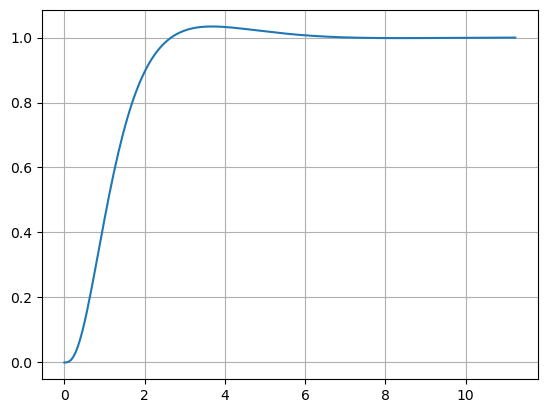

In [12]:
from matplotlib import pyplot as plt
plt.plot(t,y[0,0,:])
plt.grid()

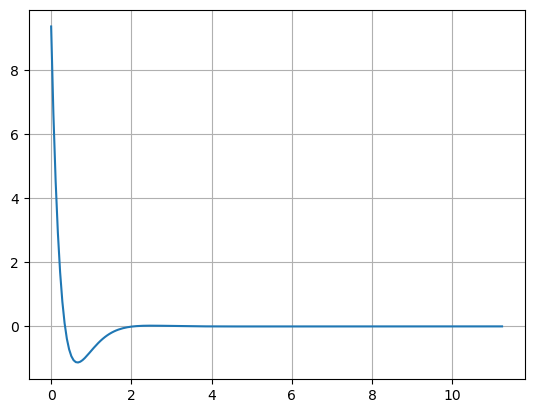

In [13]:
plt.plot(t,y[1,0,:])
plt.grid()